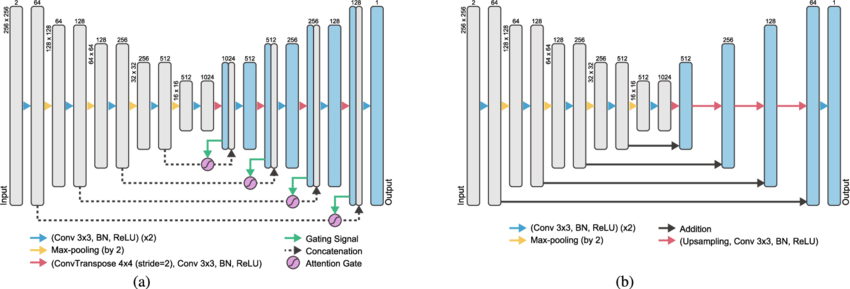



In [ ]:
"""
Multiclass semantic segmentation using Linknet and how does it compare against unet
Original paper on Unet: (2015)
    https://arxiv.org/pdf/1505.04597.pdf
    
Original paper on Linknet: (2017)
    https://arxiv.org/pdf/1707.03718.pdf
    
Can learn a bit more about backbone comparison here....
https://iopscience.iop.org/article/10.1088/1742-6596/1544/1/012196/pdf
To annotate images and generate labels, you can use APEER (for free):
www.apeer.com 
"""

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import pandas as pd
from datetime import datetime 

from keras.utils import normalize
#from keras.metrics import MeanIoU


#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("128_patches/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 1)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)#(1600,128,128,3)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("128_patches/masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)#(1600,128,128)

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#################################################
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)#(1600,128,128,1)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

######################################################
#Reused parameters in all models

n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# this line actually copy 
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss() # that is great when it's comes to balancing and unbalanced dataset also handling the dataset when one phases is easy is or one pahses is easier to segment compared to the other 
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


########################################################################

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)
#####################################################################
###Model 1
#Using same backbone for both models

# define model (Change to unet or Linknet based on the need )
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

start1 = datetime.now() 

history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

stop1 = datetime.now()

#Execution time of the model 
execution_time_unet = stop1-start1
print("Unet execution time is: ", execution_time_unet)


model1.save('unet_res34_backbone_50epochs.hdf5')

# convert the history.history dict to a pandas DataFrame:     
hist1_df = pd.DataFrame(history1.history) 
hist1_csv_file = 'history_unet_50epochs.csv'
with open(hist1_csv_file, mode='w') as f:
    hist1_df.to_csv(f)
############################################################
###Model 2
#Using the same backbone as unet

# define model (Change to unet or Linknet based on the need )
model2 = sm.Linknet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)

print(model2.summary())

start2 = datetime.now() 

history2=model2.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

stop2 = datetime.now()

#Execution time of the model 
execution_time_linknet = stop2-start2
print("Linknet execution time is: ", execution_time_linknet)

model2.save('linknet_res34_backbone_50epochs.hdf5')

# convert the history.history dict to a pandas DataFrame:     
hist2_df = pd.DataFrame(history2.history) 
hist2_csv_file = 'history_linknet.csv'
with open(hist2_csv_file, mode='w') as f:
    hist2_df.to_csv(f)
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#####################################################

from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model_unet = load_model('unet_res34_backbone_50epochs.hdf5', compile=False)
model_linknet = load_model('linknet_res34_backbone_50epochs.hdf5', compile=False)

#IOU
y_pred_unet=model_unet.predict(X_test1)
y_pred_unet_argmax=np.argmax(y_pred_unet, axis=3)

y_pred_linknet=model_linknet.predict(X_test1)
y_pred_linknet_argmax=np.argmax(y_pred_linknet, axis=3)

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4

IOU_unet = MeanIoU(num_classes=n_classes)  
IOU_unet.update_state(y_test[:,:,:,0], y_pred_unet_argmax)

IOU_linknet = MeanIoU(num_classes=n_classes)  
IOU_linknet.update_state(y_test[:,:,:,0], y_pred_linknet_argmax)

print("Mean IoU using Unet =", IOU_unet.result().numpy())
print("Mean IoU using linknet =", IOU_linknet.result().numpy())


##############################################################


import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)

test_pred_unet = model_unet.predict(test_img_input1)
test_prediction_unet = np.argmax(test_pred_unet, axis=3)[0,:,:]

test_pred_linknet = model_linknet.predict(test_img_input1)
test_prediction_linknet = np.argmax(test_pred_linknet, axis=3)[0,:,:]


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(223)
plt.title('Unet result')
plt.imshow(test_prediction_unet, cmap='jet')
plt.subplot(224)
plt.title('Linknet result')
plt.imshow(test_prediction_linknet, cmap='jet')
plt.show()

###################################################################################
from patchify import patchify, unpatchify

#Set compile=False as we are not loading it for training, only for prediction.
#model_unet = load_model('saved_models/unet_res34_backbone_50epochs.hdf5', compile=False)
#model_linknet = load_model('saved_models/linknet_res34_backbone_50epochs.hdf5', compile=False)

start3 = datetime.now() 

segm_images = []
path = "50_large_images/*.tif"
from pathlib import Path
for file in glob.glob(path):
    #print(file)     #just stop here to see all file names printed
    name = Path(file).stem #Get the original file name
    #print(name)
  
    large_image = cv2.imread(file, 1)
    
    patches = patchify(large_image, (128, 128, 3), step=128)  #Step=256 for 256 patches means no overlap
    
    predicted_patches = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            print(i,j)
            
            single_patch = patches[i,j,0, :,:]
            
            single_patch = np.expand_dims(single_patch, 0)
            single_patch_input=preprocess_input1(single_patch)
    
            single_patch_prediction = (model_linknet.predict(single_patch_input))
            single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]
    
            predicted_patches.append(single_patch_predicted_img)
    
    predicted_patches = np.array(predicted_patches)
    
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )
    
    reconstructed_image = unpatchify(predicted_patches_reshaped, (large_image.shape[0], large_image.shape[1]))
    #Here you can save individual images, or save on milti_dim tiff file
    #cv2.imwrite('segmented_images/' + name + '_segmented.tif', reconstructed_image)
    segm_images.append(reconstructed_image)
    print("Finished segmenting image: ", name)
    
    
final_segm_image = np.array(segm_images).astype(np.uint8)   

from tifffile import imsave
imsave('segmented_images/sandstone_segmented_test2.tif', final_segm_image)
    
stop3 = datetime.now()

#Execution time of the model 
#prediction_time_unet = stop3-start3
prediction_time_linknet = stop3-start3
print("Linknet prediction time is: ", prediction_time_linknet)